# Esports Tournament Linear Regression Model

## Import all Modules

In [23]:
import json
from statistics import mode
from numpy import NaN
import pandas as pd
from json import encoder
import datetime 
from sklearn import preprocessing
from sqlalchemy import column, create_engine
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from pprint import pprint as pp
from pandasgui import show
import statsmodels.formula.api as smf
import plotly.graph_objects as go
import plotly.express as px
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn import model_selection
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from statsmodels.graphics import gofplots as sm
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std#
from scipy import stats

## Import all Data

In [24]:
pd.reset_option('display.max_rows')
CSdf = pd.read_csv('CSGO.csv')
Dotadf = pd.read_csv('Dota_2.csv')
PUBGdf = pd.read_csv('PUBG.csv')
R6df = pd.read_csv('R6.csv')
RLdf = pd.read_csv('RL.csv')
tournament_df = pd.read_json('tour2.json')
T7df = pd.read_csv('T7.csv')

gamedfs = [CSdf, Dotadf, PUBGdf, R6df, RLdf, T7df]
game_names = ['CSGO', 'D2', 'PUBG', 'R6', 'RL', 'T7' ]



## Clean all game data frames

In [25]:
def df_clean(dfs,game_str):
    
    final_games = pd.DataFrame()

    for df, g_str in zip(dfs, game_str):
        df['DateTime'] = pd.to_datetime(df['DateTime'])
        df = df.drop(columns=['Flags', 'Players Trend'], errors='ignore' )
        df = df.dropna(axis=0)
        df.reset_index(drop=True, inplace=True)
        df['Game_gain'] = df.Players - df.Players.shift(1)
        df['Twitch_gain'] = df['Twitch Viewers'] - df['Twitch Viewers'].shift(1)        
        df['Game:'] = g_str
        df['Prev_views'] = df['Twitch Viewers'].shift(1)
        df['Prev_players'] = df['Players'].shift(1)
        #df['Prev_date'] = df['Start Date'].shift(1)
        #df = df.drop([0]) 
        
        final_games = final_games.append(df,sort=False)
        final_games.reset_index(drop=True, inplace=True)
    return final_games

figuresdf = df_clean(gamedfs,game_names)

## Clean tournament dataframe

In [26]:


tournament_df = tournament_df.drop(columns=['Currency:', 'Exchange Rate:'])
tournament_df['Start Date'] = tournament_df['Date:'].str[:10]
tournament_df['End Date'] = tournament_df['Date:'].str[-10:]
tournament_df['Prize Pool'] = tournament_df['Prize Pool:'].apply(lambda x: str(x).split('(')[-1] )
tournament_df['Location:'] = tournament_df['Location:'].apply(lambda x: str(x).split(',')[-1] )
tournament_df['Location:'] = tournament_df['Location:'].str.strip()
tournament_df['Prize Pool'] = tournament_df['Prize Pool'].str.replace(r'\D+', '')
tournament_df = tournament_df.drop(columns=['Date:', 'Prize Pool:'])
tournament_df['End Date'] = pd.to_datetime(tournament_df['End Date'])
tournament_df['Start Date'] = pd.to_datetime(tournament_df['Start Date'])
tournament_df['Prize Pool'] = tournament_df['Prize Pool'].astype(float)
tournament_df['Tour_days'] = (tournament_df['End Date'] - tournament_df['Start Date']).dt.days
drop_tour_locs = {'Offline', 'N/A', 'Asia', 'Southeast Asia', 'South USA', 'Europe', 'Middle East', 'USAs', 'Latin USA', 'Americas', 'Latin America', 'South America', 'Americas'}
tournament_df.drop(tournament_df.loc[tournament_df['Location:'] == drop_tour_locs].index, inplace=True)


game_title_replace = {'Counter-Strike: Global Offensive' : 'CSGO', 'Dota 2' : 'D2', 'PLAYERUNKNOWN’S BATTLEGROUNDS' : 'PUBG', 'Rocket League' : 'RL', 'Tekken 7' : 'T7'}
tournament_df['Game:'] = tournament_df['Game:'].replace(game_title_replace)
tournament_df.drop(tournament_df[tournament_df['Tour_days'] >= 5].index, inplace=True)
tournament_df['Tour_days'] = (tournament_df['Tour_days'] + 1)





## Merge frames

In [27]:
pd.set_option("display.max_rows", 400)
pd.options.display.max_rows = 10
#pd.reset_option("display.max_rows")
final_frame = pd.merge(tournament_df, figuresdf, left_on=['Game:','Start Date'], right_on=['Game:','DateTime'], how='inner')
final_frame = final_frame.drop(columns=['T,o,u,r','End Date' ])
vals = final_frame['DateTime'].value_counts()

## Clean up location strings

In [28]:
rename_locs = {'Germay' : 'Germany', 'Online (Twitch)' : 'Online','online' : 'Online', 'South Africa' : 'SouthA', 'Taipei City': 'Taipei', 'Unites States' : 'USA', 'Europe/Americas/OCE' : 'drop',  'United Kingdom' : 'UK', 'United States' : 'USA', 'United Arab Emirates' : 'UAE', 'Texas' : 'USA', 'Madrid' : 'Spain', '(Spain)' : 'Spain', 'Hong Kong' : 'China', 'America' : 'USA','Philadelphia' : 'USA', 'Sydney' : 'Australia', 'Toronto' : 'USA',  'AMERICAS' : 'USA', 'North America' : 'USA'}
rename_city = {'TX' : 'USA', 'Parc des Expositions de la porte de Versailles' : 'France', 'Dominican Republic' : 'DomPublic', 'Madrid (Spain)' : 'Spain',  'Fresno' : 'USA', 'Al Khobar' : 'Saudi Arabia', 'IL' : 'USA', 'Taipei' : 'Taiwan', 'Taiwan City' : 'Taiwan', 'Chantilly' : 'France', 'Spain Spain' : 'Spain' , 'Kettering' : 'UK', 'Macao' : 'China', 'Berlin' : 'Germany', 'Fersno' : 'USA' , 'Wien' : 'Austria', 'Québec' : 'Canada', 'Saudi arabia' : 'Saudi Arabia', 'Bogotá' : 'Columbia', 'Fukuoka' : 'Japan', 'China (offline)' : 'China',  'NV' : 'USA',  'North USA' : 'USA', 'Colmar' : 'France', 'La Rochelle' : 'France', 'Brussels' : 'Belgium' , 'Copenhagen' : 'Denmark',  'Fredericia' : 'Denmark', 'Seoul' : 'SK', 'South Korea' : 'SK', 'Korea' : 'SK',  'Rome' : 'Italy', 'São Paulo': 'Brazil', 'Dublin' : 'Ireland', 'Jakarta' : 'Indonesia',  'NJ' : 'USA', 'Poitiers' : 'France', 'New Jersey' : 'USA', 'Seattle' : 'USA', 'Santa Ana' : 'USA',   'Dallas' : 'USA', 'CA' : 'USA', 'CT': 'USA', 'Bangkok' : 'Thailand', 'Richmond' : 'USA', 'Tokyo' : 'Japan',  'Sweden.' : 'Sweden', 'MA' : 'USA', 'San Jose' : 'USA', 'MaCanadao' : 'Canada', 'SC' : 'USA', 'Changsha' : 'China', 'Riyadh' : 'Saudi Arabia',  'Florida' : 'USA', 'London' : 'UK' , 'Stockholm Sweden.' : 'Sweden' , 'BC' : 'USA', 'Oslo' : 'Norway', 'MaCanadao' : 'Canada', 'Dubai' : 'UAE' ,'China (offline)' : 'China', 'Birmingham' : 'UK', 'Munich' : 'Germany', 'Pennsylvania' : 'USA' , 'Moscow': 'Russia', 'Elmhurst' : 'USA', 'NA' : 'USA' , 'FL' : 'USA', 'Montreal' : 'Canada', 'Ghent' : 'Belgium' , 'Tennessee' : 'USA' ,  'Barcelona' : 'Spain', 'Shanghai' : 'China', 'California' : 'USA' , 'Zürich' : "Switzerland", 'Mechelen' : 'Belgium', 'GA' : 'Georgia', 'Paris' : 'France',  'Manila' : 'Philippines', 'Chiba': 'Japan', 'Lille' : 'France', 'Flordia' : 'USA', 'Bern' : 'Switzerland', 'Los Angeles' : 'USA', 'San Francisco' : 'USA', 'MaCanadau' : 'Canada' , 'MaCanadao' : 'Canada', 'MaCanadau' : 'Canada', 'Kyiv' : 'Ukraine' , 'ca' : 'Canada'}
final_frame['Location:'] = final_frame['Location:'].replace(rename_locs)
final_frame['Location:'] = final_frame['Location:'].replace(rename_city)
final_frame.drop(final_frame.loc[final_frame['Location:'] == 'drop'].index, inplace=True)
final_frame.drop(final_frame.loc[final_frame['Location:'] == 'Europe'].index, inplace=True)

## Tidy up column names

In [29]:
final_frame.rename(columns={'Game_Counter-Strike:_Global_Offensive' : 'CSGO', 'Game_Dota_2' : 'D2', 'Game_PLAYERUNKNOWN’S_BATTLEGROUNDS' : 'PUBG', 'Game_Rainbow_Six_Siege' : 'R6', 'Game_Rocket_League' : 'RL', 'Game_Tekken_7' : 'T7'}, inplace=True)
final_frame.columns = final_frame.columns.str.replace(' ', '_')
final_frame = final_frame.drop(columns=['Start_Date', 'DateTime' ])
final_frame = final_frame.replace(0, np.nan)
final_frame = final_frame.dropna(axis=0)
vals = final_frame['Location:'].value_counts()
print(vals)


Online      599
USA         438
China       132
SK           89
UK           62
           ... 
Barhain       1
Offline       1
Mexico        1
Columbia      1
Chile         1
Name: Location:, Length: 68, dtype: int64


## Create dummies for location and game categories

In [30]:
game_dummies = pd.get_dummies(final_frame['Game:'], prefix='Game' )
game_location_dummies = pd.get_dummies(final_frame['Location:'])
final_frame = pd.concat([final_frame, game_dummies], axis=1)
final_frame = pd.concat([final_frame, game_location_dummies], axis=1)
final_frame.drop(columns=[ 'Game:' , 'Location:', 'Game_CSGO', 'Americas' ], inplace=True)
final_frame.columns = final_frame.columns.str.replace(' ', '_')


In [31]:
# cor = final_frame.corr()
# plt.figure(figsize = (100,50))
# sns.heatmap(cor, annot = True)
# plt.show()
final_frame

,Prize_Pool,Tour_days,Players,Twitch_Viewers,Game_gain,Twitch_gain,Prev_views,Prev_players,Game_D2,Game_PUBG,...,Sweden,Switzerland,Taiwan,Thailand,Turkey,UAE,UK,USA,Ukraine,Vietnam
0,150000000.0,4,592038.0,70899.0,10350.0,-6267.0,77166.0,581688.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,76500000.0,3,487648.0,151445.0,-21585.0,38956.0,112489.0,509233.0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,66000000.0,3,575434.0,122903.0,53590.0,68126.0,54777.0,521844.0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,19631835.0,3,575434.0,122903.0,53590.0,68126.0,54777.0,521844.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,19631835.0,3,575434.0,122903.0,53590.0,68126.0,54777.0,521844.0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2146,1606320.0,4,807696.0,133528.0,33602.0,67062.0,66466.0,774094.0,1,0,...,0,0,0,0,0,0,0,0,0,0
2147,1524000.0,3,690311.0,141141.0,42040.0,-12358.0,153499.0,648271.0,1,0,...,0,0,0,0,0,0,0,0,0,0
2148,1524000.0,3,690311.0,141141.0,42040.0,-12358.0,153499.0,648271.0,1,0,...,0,0,0,0,0,0,0,0,0,0
2149,1500000.0,1,847525.0,76162.0,-37416.0,-48739.0,124901.0,884941.0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# scalar = StandardScaler()
# final_frame = pd.DataFrame(scalar.fit_transform(final_frame.values), columns=final_frame.columns, index=final_frame.index)

array([[<AxesSubplot:title={'center':'Twitch_Viewers'}>,
        <AxesSubplot:title={'center':'Prev_views'}>],
       [<AxesSubplot:title={'center':'Prev_players'}>,
        <AxesSubplot:title={'center':'Prize_Pool'}>],
       [<AxesSubplot:title={'center':'Game_gain'}>,
        <AxesSubplot:title={'center':'Twitch_gain'}>]], dtype=object)

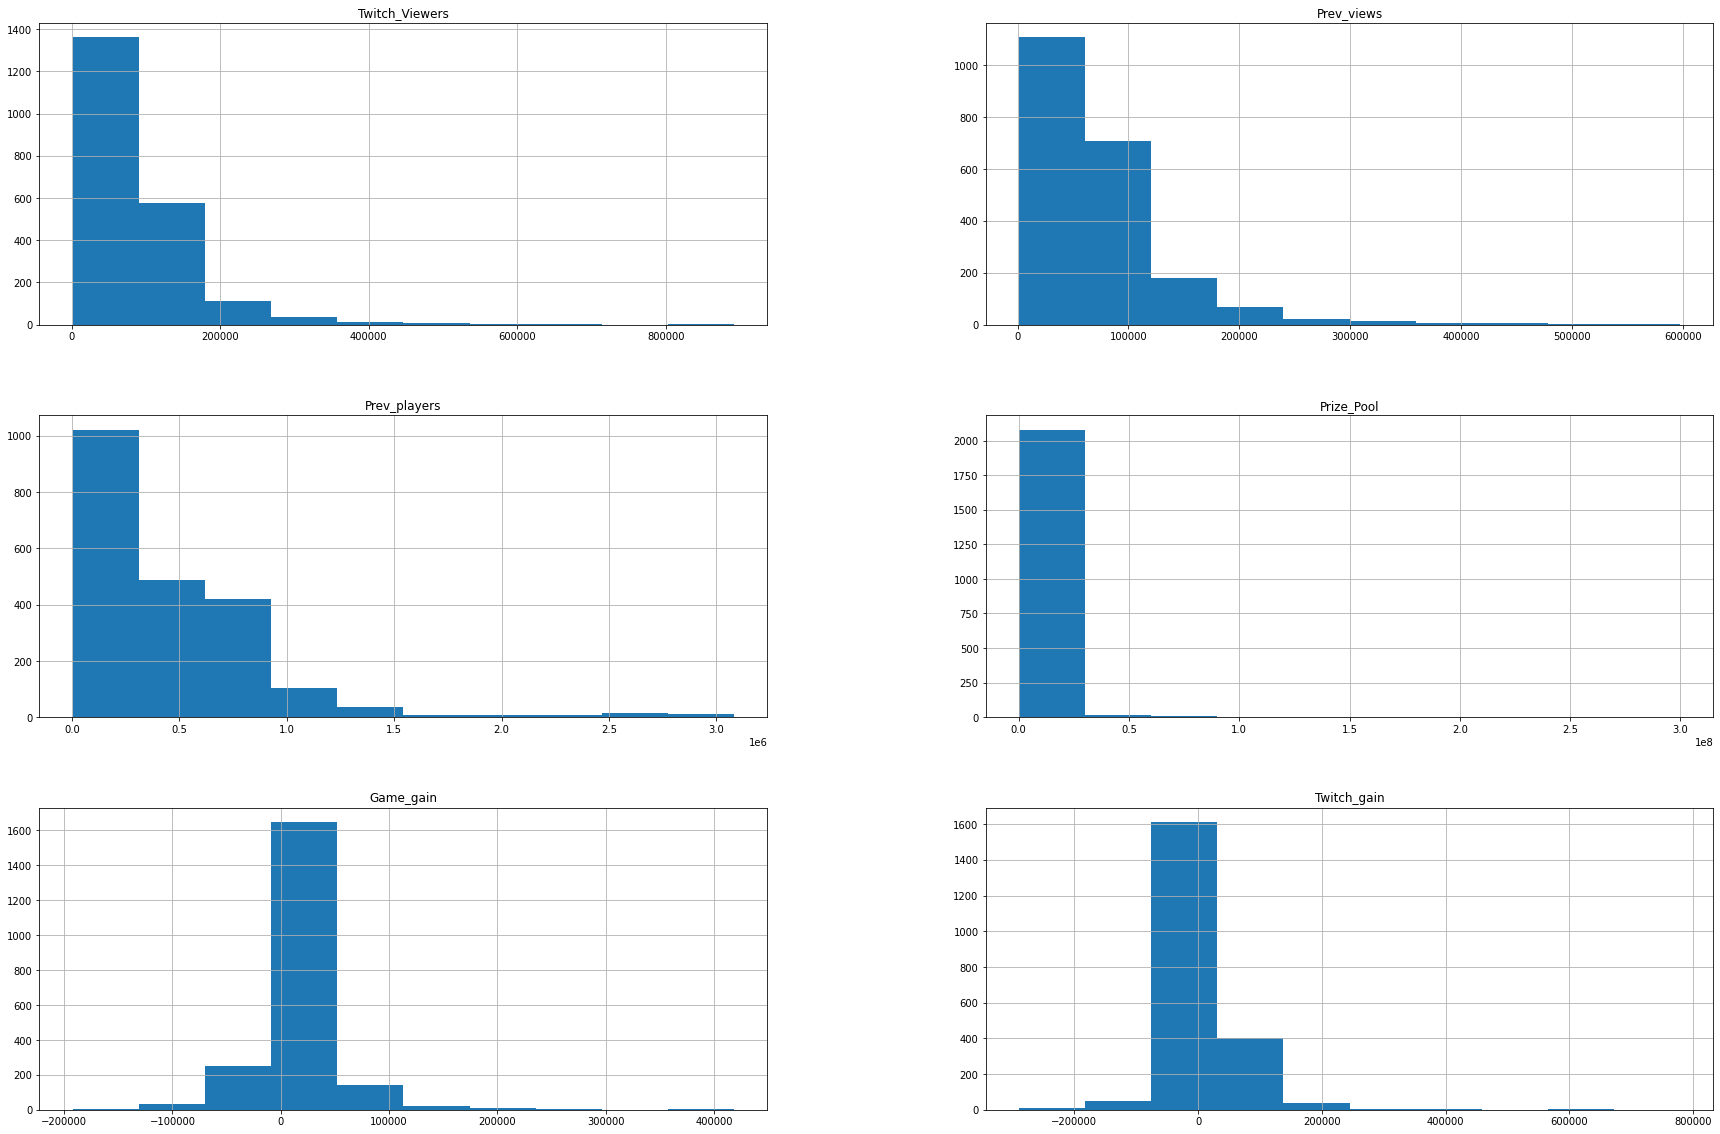

In [33]:
final_frame.hist(column= ['Twitch_Viewers', 'Prev_views', 'Prev_players', 'Prize_Pool','Game_gain','Twitch_gain'], figsize=(30, 20))

Quite a few columns of our data are very skewed and not normalised we can apply transforms to try and normalise them. 

In [34]:

final_frame['Twitch_Viewers'] = stats.boxcox(final_frame['Twitch_Viewers'])[0]
final_frame['Prev_views'] = stats.boxcox(final_frame['Prev_views'])[0]
final_frame['Prev_players'] = stats.boxcox(final_frame['Prev_players'])[0]
final_frame['Prize_Pool'] = stats.boxcox(final_frame['Prize_Pool'])[0]
final_frame['Players'] = stats.boxcox(final_frame['Players'])[0]


final_frame

,Prize_Pool,Tour_days,Players,Twitch_Viewers,Game_gain,Twitch_gain,Prev_views,Prev_players,Game_D2,Game_PUBG,...,Sweden,Switzerland,Taiwan,Thailand,Turkey,UAE,UK,USA,Ukraine,Vietnam
0,24.939295,4,95.223033,64.459603,10350.0,-6267.0,73.673066,97.121378,0,0,...,0,0,0,0,0,0,0,0,0,0
1,23.796820,3,90.736178,79.145162,-21585.0,38956.0,81.965057,93.931687,0,0,...,0,0,0,0,0,0,1,0,0,0
2,23.549250,3,94.552011,74.815519,53590.0,68126.0,66.832413,94.510616,0,0,...,0,0,0,0,0,0,0,1,0,0
3,21.555070,3,94.552011,74.815519,53590.0,68126.0,66.832413,94.510616,0,0,...,0,0,0,0,0,0,0,0,0,0
4,21.555070,3,94.552011,74.815519,53590.0,68126.0,66.832413,94.510616,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2146,17.650451,4,102.853641,76.506926,33602.0,67062.0,70.615435,104.328247,1,0,...,0,0,0,0,0,0,0,0,0,0
2147,17.571353,3,98.925184,77.658251,42040.0,-12358.0,89.468316,99.796447,1,0,...,0,0,0,0,0,0,0,0,0,0
2148,17.571353,3,98.925184,77.658251,42040.0,-12358.0,89.468316,99.796447,1,0,...,0,0,0,0,0,0,0,0,0,0
2149,17.547510,1,104.087436,65.726292,-37416.0,-48739.0,84.421545,107.877551,1,0,...,0,0,0,0,0,0,0,0,0,0


I applied the box cox transform as after testing against square root and log transforms it gave the best results. 

,Prize_Pool,Tour_days,Players,Twitch_Viewers,Game_gain,Twitch_gain,Prev_views,Prev_players,Game_D2,Game_PUBG,...,Sweden,Switzerland,Taiwan,Thailand,Turkey,UAE,UK,USA,Ukraine,Vietnam
0,24.939295,4,95.223033,64.459603,10350.0,-6267.0,73.673066,97.121378,0,0,...,0,0,0,0,0,0,0,0,0,0
1,23.796820,3,90.736178,79.145162,-21585.0,38956.0,81.965057,93.931687,0,0,...,0,0,0,0,0,0,1,0,0,0
2,23.549250,3,94.552011,74.815519,53590.0,68126.0,66.832413,94.510616,0,0,...,0,0,0,0,0,0,0,1,0,0
3,21.555070,3,94.552011,74.815519,53590.0,68126.0,66.832413,94.510616,0,0,...,0,0,0,0,0,0,0,0,0,0
4,21.555070,3,94.552011,74.815519,53590.0,68126.0,66.832413,94.510616,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2146,17.650451,4,102.853641,76.506926,33602.0,67062.0,70.615435,104.328247,1,0,...,0,0,0,0,0,0,0,0,0,0
2147,17.571353,3,98.925184,77.658251,42040.0,-12358.0,89.468316,99.796447,1,0,...,0,0,0,0,0,0,0,0,0,0
2148,17.571353,3,98.925184,77.658251,42040.0,-12358.0,89.468316,99.796447,1,0,...,0,0,0,0,0,0,0,0,0,0
2149,17.547510,1,104.087436,65.726292,-37416.0,-48739.0,84.421545,107.877551,1,0,...,0,0,0,0,0,0,0,0,0,0


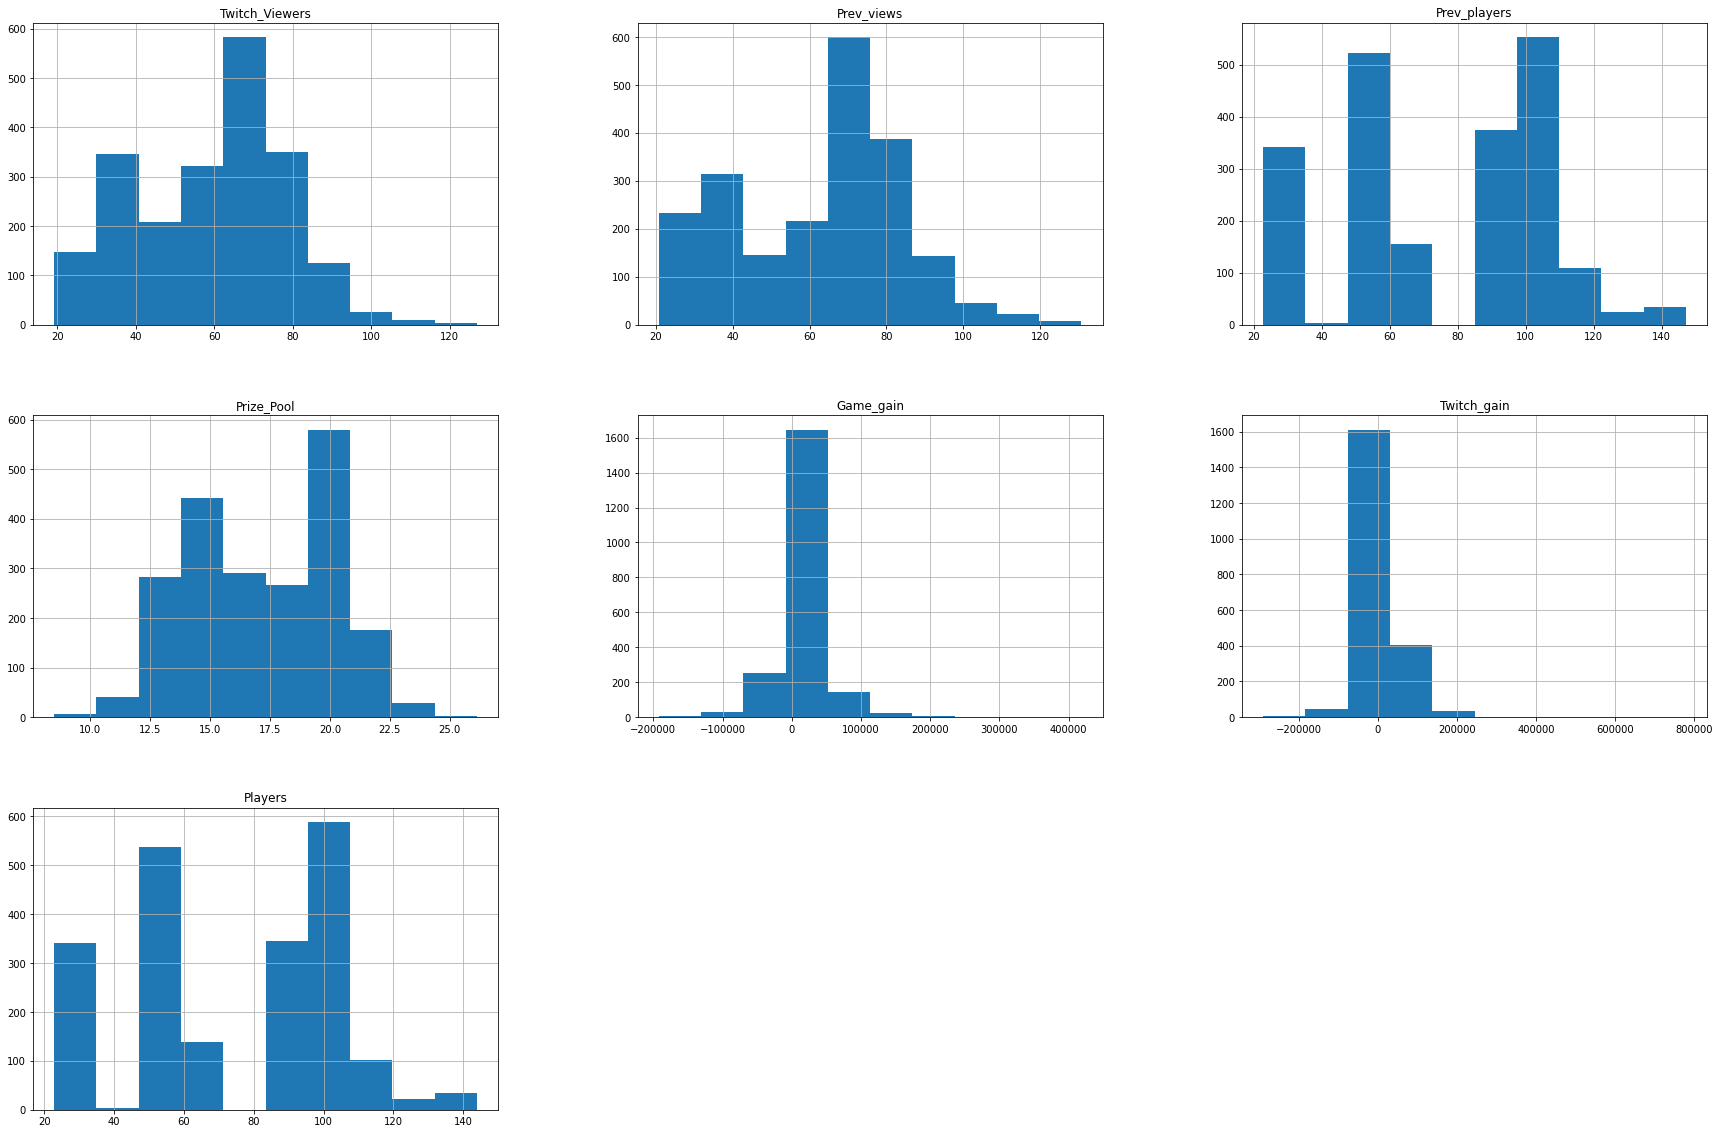

In [35]:
final_frame.hist(column= ['Twitch_Viewers', 'Prev_views', 'Prev_players', 'Prize_Pool','Game_gain','Twitch_gain', 'Players'], figsize=(30, 20))
final_frame

We can see that the data is more normalised and no column is skewed anymore so we can proceed. 

## Check for collinearity 

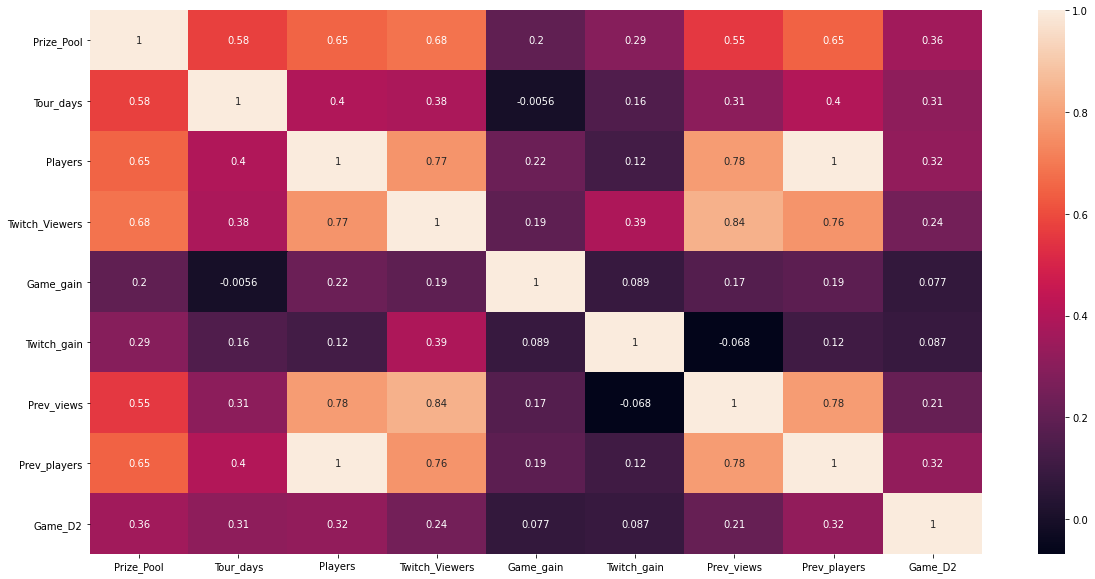

In [36]:
cor = final_frame.corr()
plt.figure(figsize = (20,10))
sns.heatmap(cor.iloc[0:9,0:9], annot = True)
plt.show()

We can see perfect correlation between Players and Prev_players so will have to drop one. I'm going to pick Players though either would do as the sum of their rows is the same. 

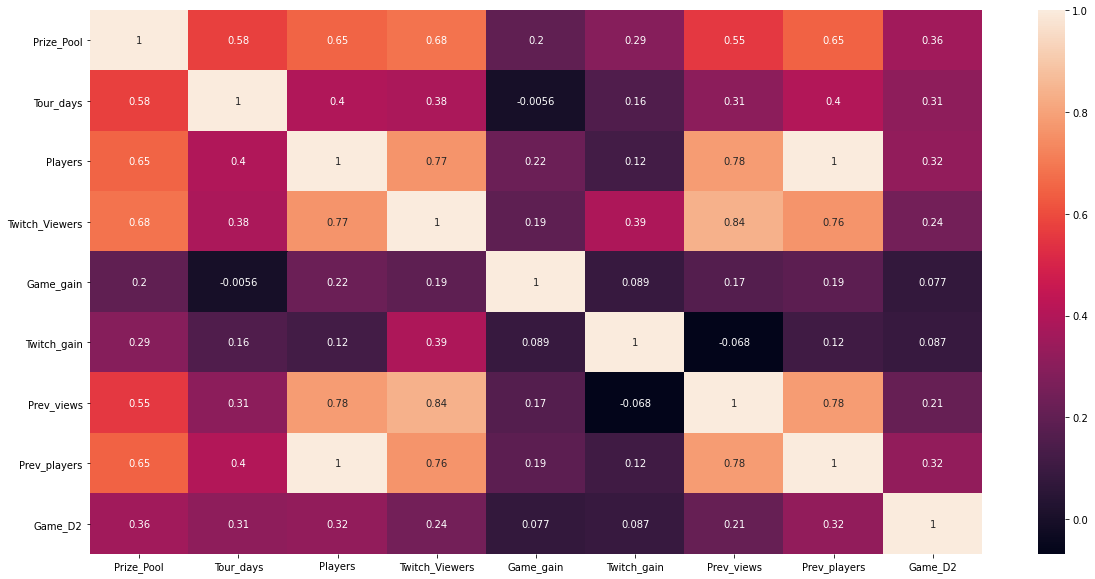

In [37]:
final_frame.drop(columns=[], inplace=True)
cor = final_frame.corr()
plt.figure(figsize = (20,10))
sns.heatmap(cor.iloc[0:9,0:9], annot = True)
plt.show()

There are also very strong correlations bettwen Twtich Viewers and Twtich previous viewers. Also with Game previous players and the game PUBG. I will not remove these values yet and see it they effect the outcome before making a decision. 

In [38]:
px.histogram(final_frame, "Twitch_gain", marginal="violin", title="Histogram of Twitch Viewers (response)")

In [39]:
final_frame.drop(final_frame.loc[final_frame['Twitch_gain'] < -120000].index, inplace=True)
final_frame.drop(final_frame.loc[final_frame['Twitch_gain'] > 200000].index, inplace=True)
final_frame

,Prize_Pool,Tour_days,Players,Twitch_Viewers,Game_gain,Twitch_gain,Prev_views,Prev_players,Game_D2,Game_PUBG,...,Sweden,Switzerland,Taiwan,Thailand,Turkey,UAE,UK,USA,Ukraine,Vietnam
0,24.939295,4,95.223033,64.459603,10350.0,-6267.0,73.673066,97.121378,0,0,...,0,0,0,0,0,0,0,0,0,0
1,23.796820,3,90.736178,79.145162,-21585.0,38956.0,81.965057,93.931687,0,0,...,0,0,0,0,0,0,1,0,0,0
2,23.549250,3,94.552011,74.815519,53590.0,68126.0,66.832413,94.510616,0,0,...,0,0,0,0,0,0,0,1,0,0
3,21.555070,3,94.552011,74.815519,53590.0,68126.0,66.832413,94.510616,0,0,...,0,0,0,0,0,0,0,0,0,0
4,21.555070,3,94.552011,74.815519,53590.0,68126.0,66.832413,94.510616,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2146,17.650451,4,102.853641,76.506926,33602.0,67062.0,70.615435,104.328247,1,0,...,0,0,0,0,0,0,0,0,0,0
2147,17.571353,3,98.925184,77.658251,42040.0,-12358.0,89.468316,99.796447,1,0,...,0,0,0,0,0,0,0,0,0,0
2148,17.571353,3,98.925184,77.658251,42040.0,-12358.0,89.468316,99.796447,1,0,...,0,0,0,0,0,0,0,0,0,0
2149,17.547510,1,104.087436,65.726292,-37416.0,-48739.0,84.421545,107.877551,1,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
px.histogram(final_frame, "Twitch_gain", marginal="violin", title="Histogram of Twitch Gain (response)")

After removing our outliers we can see we have a much better distribution.

In [41]:
final_frame

,Prize_Pool,Tour_days,Players,Twitch_Viewers,Game_gain,Twitch_gain,Prev_views,Prev_players,Game_D2,Game_PUBG,...,Sweden,Switzerland,Taiwan,Thailand,Turkey,UAE,UK,USA,Ukraine,Vietnam
0,24.939295,4,95.223033,64.459603,10350.0,-6267.0,73.673066,97.121378,0,0,...,0,0,0,0,0,0,0,0,0,0
1,23.796820,3,90.736178,79.145162,-21585.0,38956.0,81.965057,93.931687,0,0,...,0,0,0,0,0,0,1,0,0,0
2,23.549250,3,94.552011,74.815519,53590.0,68126.0,66.832413,94.510616,0,0,...,0,0,0,0,0,0,0,1,0,0
3,21.555070,3,94.552011,74.815519,53590.0,68126.0,66.832413,94.510616,0,0,...,0,0,0,0,0,0,0,0,0,0
4,21.555070,3,94.552011,74.815519,53590.0,68126.0,66.832413,94.510616,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2146,17.650451,4,102.853641,76.506926,33602.0,67062.0,70.615435,104.328247,1,0,...,0,0,0,0,0,0,0,0,0,0
2147,17.571353,3,98.925184,77.658251,42040.0,-12358.0,89.468316,99.796447,1,0,...,0,0,0,0,0,0,0,0,0,0
2148,17.571353,3,98.925184,77.658251,42040.0,-12358.0,89.468316,99.796447,1,0,...,0,0,0,0,0,0,0,0,0,0
2149,17.547510,1,104.087436,65.726292,-37416.0,-48739.0,84.421545,107.877551,1,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

feature_data = ["Prize_Pool", 'Prev_views', 'Game_gain']


rows = (len(feature_data) // 2) +1
cols = 2
subplot_titles = tuple(var + " vs Twitch_gain" for var in feature_data)
fig = make_subplots(rows=rows, cols=cols, subplot_titles=subplot_titles)

for i, cat in enumerate(feature_data):
    row = (i // cols) + 1
    col = (i % cols) + 1
    
    fig.add_trace(go.Scatter(
        x=final_frame[cat], y=final_frame['Twitch_gain'], mode="markers"
    ), row=row, col=col)
    
    
    
fig.update_layout(height=1000, title="Scatter plots of feature vs Sale Price", showlegend=False)
fig.show()

Prize pool: Strong trend with prize pool and seems to be somewhat increasing with the figures will be removing the outliners above 3Million to investigate the trend further.
Twitch previous viewers(Prev_views): There is a clear liner relationship here which statifies the first assumption on linear regression. Will be looking to remove outliers above 43k.
Game previous players(Prev_players): Another relationship that seems to be linear and will remove outliers above 1.7M and analysis further. 

,Prize_Pool,Tour_days,Players,Twitch_Viewers,Game_gain,Twitch_gain,Prev_views,Prev_players,Game_D2,Game_PUBG,...,Sweden,Switzerland,Taiwan,Thailand,Turkey,UAE,UK,USA,Ukraine,Vietnam
0,24.939295,4,95.223033,64.459603,10350.0,-6267.0,73.673066,97.121378,0,0,...,0,0,0,0,0,0,0,0,0,0
1,23.796820,3,90.736178,79.145162,-21585.0,38956.0,81.965057,93.931687,0,0,...,0,0,0,0,0,0,1,0,0,0
2,23.549250,3,94.552011,74.815519,53590.0,68126.0,66.832413,94.510616,0,0,...,0,0,0,0,0,0,0,1,0,0
3,21.555070,3,94.552011,74.815519,53590.0,68126.0,66.832413,94.510616,0,0,...,0,0,0,0,0,0,0,0,0,0
4,21.555070,3,94.552011,74.815519,53590.0,68126.0,66.832413,94.510616,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2146,17.650451,4,102.853641,76.506926,33602.0,67062.0,70.615435,104.328247,1,0,...,0,0,0,0,0,0,0,0,0,0
2147,17.571353,3,98.925184,77.658251,42040.0,-12358.0,89.468316,99.796447,1,0,...,0,0,0,0,0,0,0,0,0,0
2148,17.571353,3,98.925184,77.658251,42040.0,-12358.0,89.468316,99.796447,1,0,...,0,0,0,0,0,0,0,0,0,0
2149,17.547510,1,104.087436,65.726292,-37416.0,-48739.0,84.421545,107.877551,1,0,...,0,0,0,0,0,0,0,0,0,0


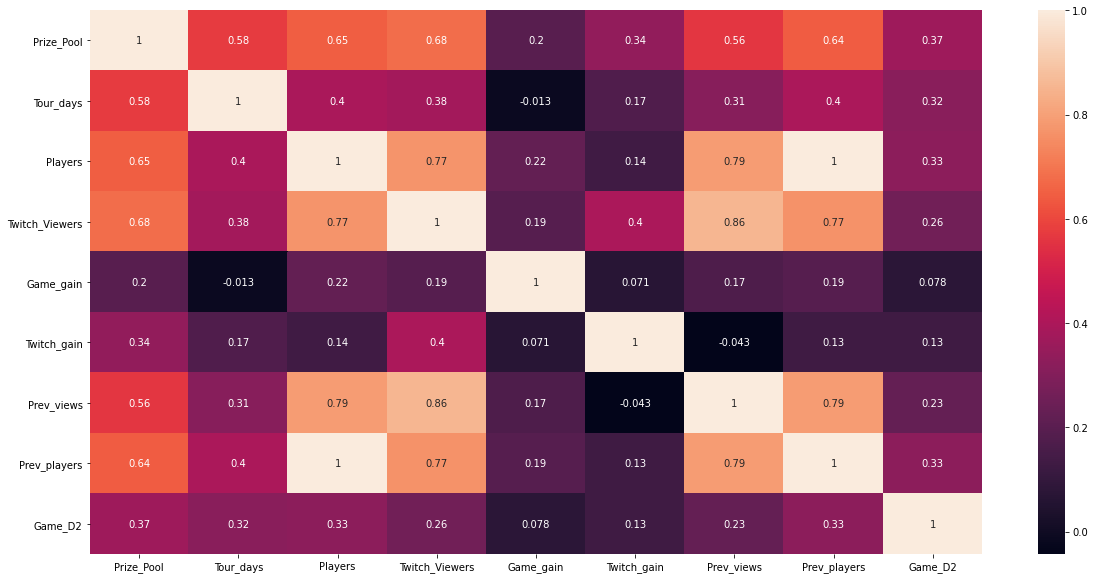

In [43]:
cor = final_frame.corr()
plt.figure(figsize = (20,10))
sns.heatmap(cor.iloc[0:9,0:9], annot = True)
final_frame

Twitch viewers has a very high collinerity with previous viewers and previous players. In fact it is perfectly colinear with previous players so can remove it from the data.

<AxesSubplot:>

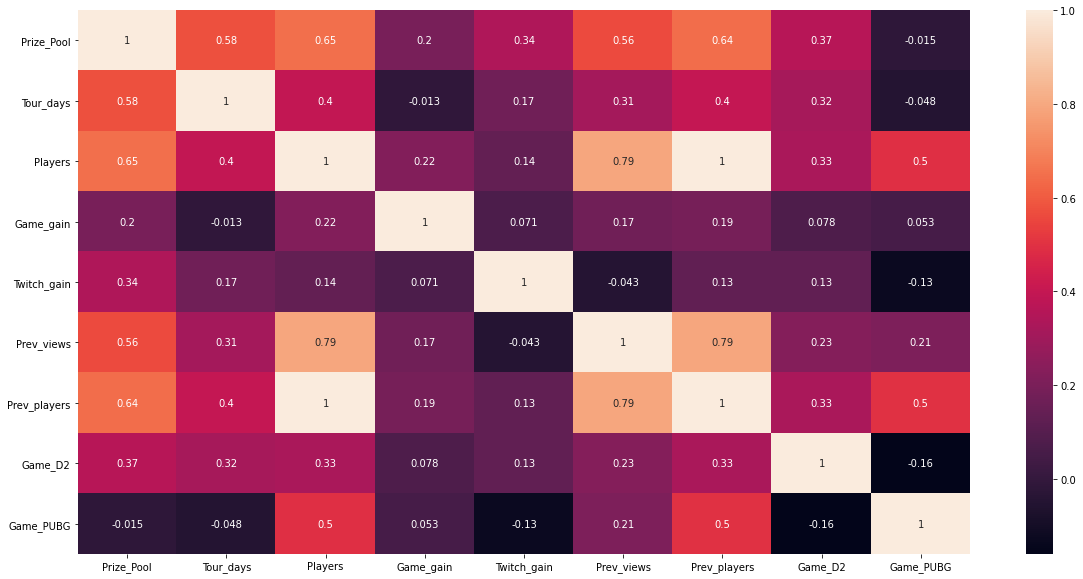

In [22]:
final_frame.drop(columns=['Twitch_Viewers'], inplace=True)
cor = final_frame.corr()
plt.figure(figsize = (20,10))
sns.heatmap(cor.iloc[0:9,0:9], annot = True)


Players has a high collinearity withmany different variables so it can be removed. 

<AxesSubplot:>

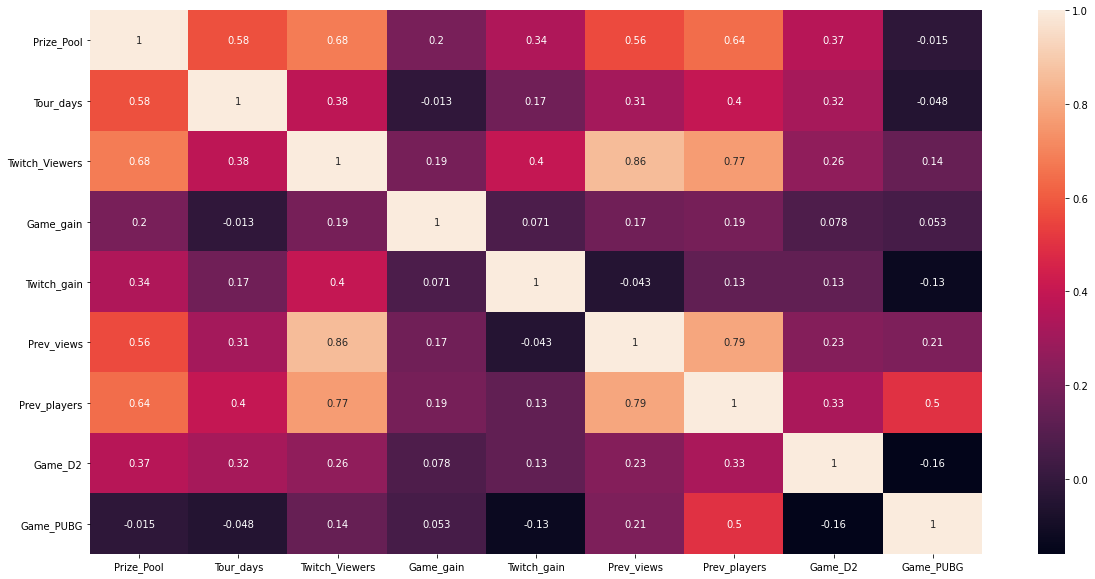

In [44]:
final_frame.drop(columns=['Players'], inplace=True)
cor = final_frame.corr()
plt.figure(figsize = (20,10))
sns.heatmap(cor.iloc[0:9,0:9], annot = True)

<AxesSubplot:>

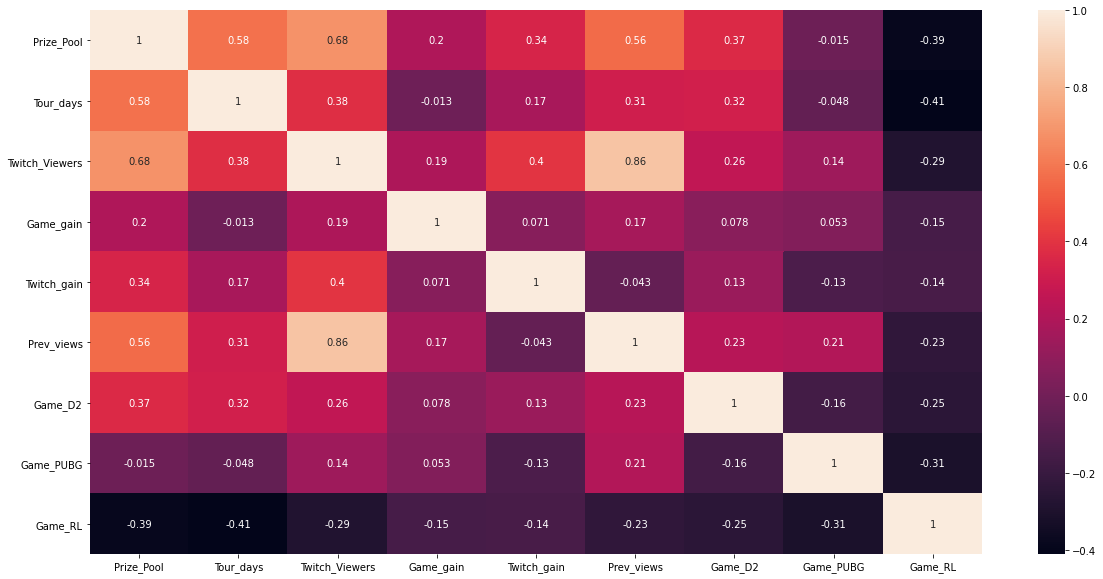

In [45]:
final_frame.drop(columns=['Prev_players'], inplace=True)
cor = final_frame.corr()
plt.figure(figsize = (20,10))
sns.heatmap(cor.iloc[0:9,0:9], annot = True)

After dropping all variables the collinearity is much improved and I'm happy to use these columns in the model. 

In [46]:
def reduce_variables(dataframe, target):
    
    target_string = target + " ~ "
    all_columns = dataframe.columns.tolist()  
    all_columns.remove(target)
    variables = " + ".join(all_columns)
    full_string =  target_string  + variables
    
    model_fit = smf.ols(full_string, data=dataframe).fit()
    
    pvalues = model_fit.pvalues
    pvalues = pvalues.drop("Intercept")
    
    max_p = pvalues.idxmax() 
    alpha = 0.05
       
    while pvalues.max() > alpha:
        max_p = pvalues.idxmax()
        all_columns.remove(max_p)
        variables = " + ".join(all_columns)
        full_string = target_string + variables
        
        model = smf.ols(full_string, data=dataframe).fit()
        pvalues = model.pvalues
        pvalues = pvalues.drop("Intercept")

    return model, full_string


targets = ['Players']


final_model, complete_string = reduce_variables(final_frame, 'Twitch_gain')
print(final_model.summary())
fitted_params = final_model.params.to_frame()
    ## Print the model summary

fitted_vars = fitted_params.index.tolist()
fitted_vars.pop(0)


                            OLS Regression Results                            
Dep. Variable:            Twitch_gain   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     258.9
Date:                Wed, 02 Jun 2021   Prob (F-statistic):               0.00
Time:                        18:33:39   Log-Likelihood:                -23599.
No. Observations:                2083   AIC:                         4.725e+04
Df Residuals:                    2058   BIC:                         4.739e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        758.5393   3545.795      0.

'Intercept'

We have a very low R^2 value which is unfortunate which suggest twitch viewer gain is hard to model or there are more impactful variables that may describe the gain. 

First we use the reduce_variables function to build our string to fit to ols(ordinary least squares) to find our variables meeting the p_value threshold of 0.05.A good start to the model with an R^2 value of 0.634 before we have checked the residuals to meet requires two of our linearity assumptions. 

In [53]:
print(complete_string)

Twitch_gain ~ Tour_days + Twitch_Viewers + Prev_views + Game_PUBG + Game_RL + Game_T7 + Argentina + Barhain + Belarus + Belgium + Denmark + Georgia + India + Netherlands + Online + Philippines + Poland + Russia + Slovenia + Sweden + Turkey + UAE + USA + Ukraine


In [54]:
px.scatter(x=final_model.fittedvalues, y=final_model.resid, labels={"x": "Fitted Values", "y": "Residuals"}, title="Baseline model, fitted values vs residuals")

The residual follow a chaotic pattern which is inline with the linear assumptions. 

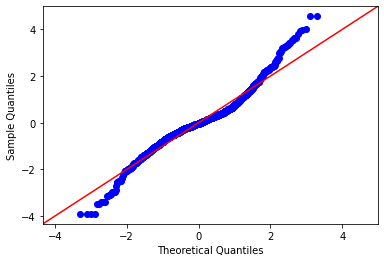

In [55]:
final_frame["fitted"] = final_model.fittedvalues
final_frame["residuals"] = final_model.resid
px.scatter(final_frame, "fitted", "residuals", title="Fitted values vs model residuals")

fig = sm.qqplot(final_frame["residuals"], fit=True, line='45')


The model residuals follow a normal distribution so we can see that rule 3 of our linear assumptions is valid.

In [56]:
#create new dataframe for the model
model_frame = final_frame[['Twitch_gain' ,'Tour_days' ,'Twitch_Viewers' ,'Prev_views' ,'Game_PUBG' , 'Game_RL', 'Game_T7' ,'Argentina', 'Barhain', 'Belarus', 'Belgium' ,'Denmark', 'Georgia',  'India',  'Netherlands' , 'Online' , 'Philippines', 'Poland', 'Russia' , 'Slovenia' , 'Sweden' , 'Turkey' ,'UAE' , 'USA' , 'Ukraine']].copy()

# Training the model

In [57]:
# pop the target column from the frame
y = model_frame.pop('Twitch_gain')


In [58]:
X_train, X_test, Y_train, Y_test = train_test_split(model_frame, y, test_size=0.3, random_state=3)
X_test, X_validation, Y_test, Y_validation = train_test_split(X_test, Y_test, test_size=0.5, random_state=3)


#initiate model a scaler
model = LinearRegression()
scaler = StandardScaler()

#scale the X features and transform the test data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_validation = scaler.transform(X_validation)

#fit our model on the training data
model.fit(X_train,Y_train)

#Run our model to predict y_hat
y_hat = model.predict(X_test)
y_val = model.predict(X_validation)
y_hat_train = model.predict(X_test)

#score our models with R^2
print(model.score(X_test,Y_test))
print(model.score(X_validation,Y_validation))
print(model.score(X_train,Y_train))


#define the splits
Cross_val = KFold(n_splits=4, random_state=3, shuffle=True)
# evaluate model
scores = cross_val_score(model, model_frame, y, scoring='accuracy', cv=Cross_val, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))



0.7352465918456919
0.7412564870297289
0.7544591157535024
Accuracy: nan (nan)
